# Funkcje definiujące model

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

X5_PERCENT = 0.2


def mini_inception_net(width, height, depth, classes, use_dropout=True, separable_convolutions=False, use_5x5=False,
                       use_gap=False):
    def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
        if separable_convolutions:
            x = layers.SeparableConv2D(K, (kX, kY), strides=stride, padding=padding)(x)
        else:
            x = layers.Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
        x = layers.BatchNormalization(axis=chanDim)(x)
        x = layers.Activation("relu")(x)

        return x

    def inception_module(x, numK1x1, numK3x3, chanDim):
        if use_5x5:
            num_sum = numK1x1 + numK3x3
            numK5x5 = round(X5_PERCENT * num_sum)
            numK1x1 = round((1 - X5_PERCENT) * numK1x1)
            numK3x3 = num_sum - numK5x5 - numK1x1  # to keep filters number constant

            conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
            conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
            conv_5x5 = conv_module(x, numK5x5, 5, 5, (1, 1), chanDim)
            x = layers.concatenate([conv_1x1, conv_3x3, conv_5x5], axis=chanDim)
        else:
            conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
            conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
            x = layers.concatenate([conv_1x1, conv_3x3], axis=chanDim)

        return x

    def downsample_module(x, K, chanDim):
        conv_3x3 = conv_module(x, K, 3, 3, (2, 2), chanDim, padding="valid")
        pool = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
        x = layers.concatenate([conv_3x3, pool], axis=chanDim)

        return x

    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input and first CONV module
    inputs = layers.Input(shape=inputShape)
    x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

    # two Inception modules followed by a downsample module
    x = inception_module(x, 32, 32, chanDim)
    x = inception_module(x, 32, 48, chanDim)
    x = downsample_module(x, 80, chanDim)

    # four Inception modules followed by a downsample module
    x = inception_module(x, 112, 48, chanDim)
    x = inception_module(x, 96, 64, chanDim)
    x = inception_module(x, 80, 80, chanDim)
    x = inception_module(x, 48, 96, chanDim)
    x = downsample_module(x, 96, chanDim)

    # two Inception modules followed by global POOL and dropout
    x = inception_module(x, 176, 160, chanDim)
    x = inception_module(x, 176, 160, chanDim)
    if use_gap:
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.AveragePooling2D((7, 7))(x)
    if use_dropout:
        x = layers.Dropout(0.5)(x)

    # softmax classifier
    x = layers.Flatten()(x)
    x = layers.Dense(classes)(x)
    x = layers.Activation("softmax")(x)

    # create the model
    model = models.Model(inputs, x, name="miniinceptionnet")

    return model


# Trenowanie sieci

In [21]:
import logging
import time
from statistics import mean

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import Callback

In [22]:
INIT_LR = 1e-2
BATCH_SIZE = 128
NUM_EPOCHS = 60
LABEL_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
def train_model(model, output_suffix):
    print("[INFO] loading CIFAR-10 dataset...")
    ((train_x, train_y), (test_x, test_y)) = cifar10.load_data()

    # scale the data to the range [0, 1]
    train_x = train_x.astype("float32") / 255.0
    test_x = test_x.astype("float32") / 255.0

    # convert the labels from integers to vectors
    label_binarizer = LabelBinarizer()
    train_y = label_binarizer.fit_transform(train_y)
    test_y = label_binarizer.fit_transform(test_y)

    # construct the image generator for data augmentation
    augmenter = ImageDataGenerator(rotation_range=18, zoom_range=0.15,
                                   width_shift_range=0.2, height_shift_range=-.2, shear_range=0.15,
                                   horizontal_flip=True, fill_mode="nearest")

    # initialize the optimizer and compile the model
    optimizer = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
    print("[INFO] training network...")
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.summary()

    # train the network
    time_callback = TimeHistory()
    history = model.fit_generator(
        augmenter.flow(train_x, train_y, batch_size=BATCH_SIZE),
        validation_data=(test_x, test_y),
        steps_per_epoch=train_x.shape[0] // BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose=1,
        callbacks=[time_callback]
    )

    # save model
    model.save("miniinception_{}".format(output_suffix))

    # evaluate the network
    print("[INFO] evaluating network...")
    predictions = model.predict(test_x, batch_size=BATCH_SIZE)
    print(classification_report(test_y.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names=LABEL_NAMES))

    train_losses = history.history["loss"]
    val_losses = history.history["val_loss"]
    train_accuracies = history.history["accuracy"]
    val_accuracies = history.history["val_accuracy"]
    zipped_results = zip(train_losses, train_accuracies, val_losses, val_accuracies)

    output_accuracy = open("accuracy_{}.txt".format(output_suffix), "w")
    for index, (train_loss, train_accuracy, val_loss, val_accuracy) in enumerate(zipped_results):
        output_accuracy.write("{} {} {} {} {}\n".format(index + 1, train_loss, train_accuracy, val_loss, val_accuracy))
    output_accuracy.close()

    # determine the number of epochs and then construct the plot title
    N = np.arange(0, NUM_EPOCHS)
    title = "Loss/Accuracy bez modyfikacji sieci"

    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, history.history["loss"], label="Loss (zbiór uczący)")
    plt.plot(N, history.history["val_loss"], label="Loss (zbiór walidacyjny)")
    plt.plot(N, history.history["accuracy"], label="Accuracy (zbiór uczący)")
    plt.plot(N, history.history["val_accuracy"], label="Accuracy (zbiór walidacyjny)")
    plt.title(title)
    plt.xlabel("Epoka")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("miniinception_{}.png".format(output_suffix))

    average_epoch_time = mean(time_callback.times)
    print("Average epoch training time: {} s".format(average_epoch_time))

In [ ]:
matplotlib.use("Agg")
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)

models = [
    mini_inception_net(32, 32, 3, len(LABEL_NAMES)),
    mini_inception_net(32, 32, 3, len(LABEL_NAMES), use_dropout=False),
    mini_inception_net(32, 32, 3, len(LABEL_NAMES), separable_convolutions=True),
    mini_inception_net(32, 32, 3, len(LABEL_NAMES), use_5x5=True),
    mini_inception_net(None, None, 3, len(LABEL_NAMES), use_gap=True)
]

for index, model in enumerate(models):
    train_model(model, str(index + 1))

[INFO] loading CIFAR-10 dataset...
[INFO] training network...
Model: "miniinceptionnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 32, 32, 96)   2688        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_122 (BatchN (None, 32, 32, 96)   384         conv2d_103[0][0]                 
__________________________________________________________________________________________________
activation_128 (Activation)     (None, 32, 32, 96)   0           batch_normalization_122[0][0]    
_____________________

# Zmiana rozmiaru obrazu

In [45]:
import random
import cv2
import tensorflow.keras.models as models

In [46]:
def get_images(n):
    random.seed(100)
    (train_images, train_labels), _ = cifar10.load_data()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    chosen_images = []
    chosen_labels = []
    train_images = train_images.astype("float32") / 255.0

    for i in range(0, n):
        index = random.randrange(0, len(train_images))
        chosen_image = train_images[index]
        chosen_images.append(chosen_image)
        chosen_labels.append(class_names[train_labels[index][0]])

    return chosen_images, chosen_labels

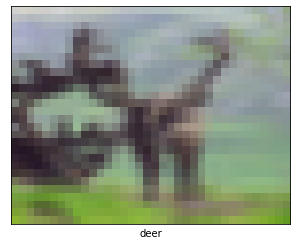

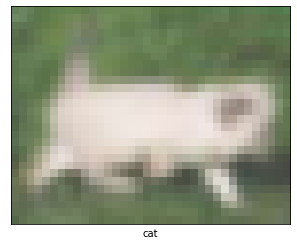

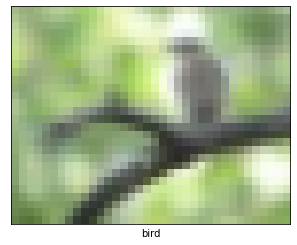

In [47]:
chosen_images, chosen_labels = get_images(3)
resized_images = []
for image in chosen_images:
    resized_images.append(cv2.resize(image, (36, 28)))

for i in range(0, 3):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(resized_images[i])
    plt.xlabel(chosen_labels[i])
    plt.savefig("cifar-{}.png".format(i))

In [ ]:
model_name = "drive/MyDrive/mro/miniinception_5"
model = models.load_model(model_name)
for image in resized_images:
    image = np.expand_dims(image, axis=0)
    pred_vec = model.predict(image, batch_size=1)
    prediction = np.argmax(pred_vec)
    print(LABEL_NAMES[prediction])

Model: "miniinceptionnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 32, 32, 96)   2688        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_206 (BatchN (None, 32, 32, 96)   384         conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_216 (Activation)     (None, 32, 32, 96)   0           batch_normalization_206[0][0]    
___________________________________________________________________________________

# Heatmapy

In [48]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
import tensorflow.keras.models as models
from skimage.transform import resize
import random

In [49]:
def get_CAM(model, image, weights):
    analysed = np.expand_dims(image, axis=0)
    gap_input, prediction_vector = model.predict(analysed)
    gap_input = np.squeeze(gap_input)
    prediction = np.argmax(prediction_vector)

    scale_factor = 32 / 7
    matrix_for_multiplication = scipy.ndimage.zoom(gap_input, (scale_factor, scale_factor, 1), order=1)
    weights_for_predicted = weights[:, prediction]
    final_output = np.dot(matrix_for_multiplication.reshape((32 * 32, 336)), weights_for_predicted).reshape(32, 32)
    return final_output, prediction

In [50]:
model_name = "drive/MyDrive/mro/miniinception_5"
model = models.load_model(model_name)
weights = model.layers[-2].get_weights()[0]
model_for_heatmap = models.Model(inputs=model.input, outputs=(model.layers[-6].output, model.layers[-1].output))
images, labels = get_images(3)

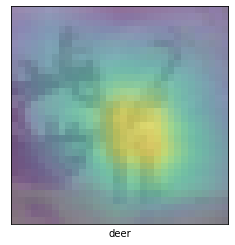

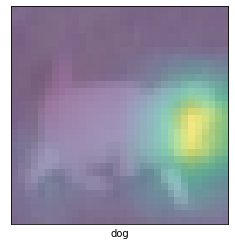

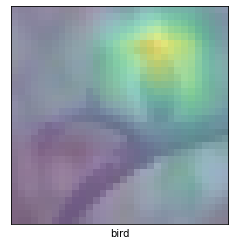

In [53]:
for i in range(len(images)):
    cam, prediction = get_CAM(model_for_heatmap, images[i], weights)
    label = LABEL_NAMES[prediction]
    
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], alpha=0.5)
    plt.imshow(cam, alpha=0.5)
    plt.xlabel(label)
    plt.savefig("heatmap-{}.png".format(i))
    plt.show()
